# imports

In [1]:
import os
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
import torchinfo
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
import spacy
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

# set the device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# dataset hyperparameters

In [3]:
batch_num = 32
# If num_workers = 0, the data loading happens in the main process (sequentially, which can be slow)
# If num_workers > 0, PyTorch will use multiple subprocesses to load the data concurrently
workers = 0
# Set to true when using GPU to prevent copying data from host memory (CPU RAM) to device memory (GPU)
pin_memory = True

# Collate

In [4]:
# Responsible for converting the individual data items returned by the __getitem__ method of custom Dataset 
# into a single batch that can be passed to the model during training or evaluation
class MyCollate:
    def __init__(self, pad_idx, split):
        self.pad_idx = pad_idx
        self.split= split

    def __call__(self, batch):
        # Get the image and change it's dimention [C, H, W] → [1, C, H, W]
        imgs = [item[0].unsqueeze(0) for item in batch]
        targets = [item[1] for item in batch]
        lengths = [item[2] for item in batch]
        
        # Concatenate all images along dim=0 to form a batch tensor of shape [batch_size, C, H, W]
        imgs = torch.cat(imgs, dim=0)
        # Use pad_sequence to pad variable-length sequences to the same length
        # batch_first=True argument means the output tensor has shape (batch_size, max_seq_length)
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        output = (imgs, targets, torch.tensor(lengths))
        
        if self.split != "train":
            allcaps = [item[3] for item in batch]  # List[List[List[int]]]
        
            # Flatten all captions across the batch
            all_captions_flat = [torch.tensor(cap) for img_caps in allcaps for cap in img_caps]
            
            # Pad ALL captions to the same max length
            padded_captions_flat = pad_sequence(all_captions_flat, batch_first=True, padding_value=self.pad_idx)
            
            # Reshape back to (batch_size, num_captions_per_image, max_len)
            num_captions_per_image = len(allcaps[0])  # e.g., 5 captions per image
            allcaps_tensor = padded_captions_flat.view(len(batch), num_captions_per_image, -1)
            
            output += (allcaps_tensor,)
        return output

# Vocabulary

In [5]:
# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, tokens):
        frequencies = Counter()

        for cap_tokens in tokens:
            # Update word frequency
            frequencies.update(cap_tokens)

        # Get the words with frequency more than a threshold
        words = [w for w in frequencies.keys() if frequencies[w] > self.freq_threshold]
        # Use v + 4 because indexes 0 to 3 are already taken
        self.stoi.update({k: v + 4 for v, k in enumerate(words)})
        self.itos.update({v + 4: k for v, k in enumerate(words)})

    def numericalize(self, text, tokenized_text):
        # Use tokens from dataset or use spacy
        # tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def textualize(self, embedding):
        # Convert tensor to list
        embedding_list = embedding.tolist()
        return " ".join(self.itos[num] for num in embedding_list)

    def tokenize_caption(self, caption, tokens):
        numericalized_caption = [self.stoi["<start>"]]
        numericalized_caption += self.numericalize(caption, tokens)
        numericalized_caption.append(self.stoi["<end>"])
        return torch.tensor(numericalized_caption)

# load data

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, tokens, split, captions_per_image=5, transform=None, freq_threshold=5):
        self.image_folder = image_folder
        self.captions_per_image = captions_per_image
        self.captions_dict = self.sample_captions(captions_dict)  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.tokens = tokens
        self.split = split
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        self.caption_lengths = [len(token) + 2 for token in self.tokens] # + 2 to consider start and end tokens
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform
        self.vocab = Vocabulary(freq_threshold) # Initialize vocabulary and build vocab
        self.vocab.build_vocabulary(self.tokens) # self.vocab.build_vocabulary(self.captions)

    # Based on image
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get all captions for the image
        captions = self.captions_dict[image_name]

        # Get one of the captions randomly for training
        random_idx = random.randrange(len(captions))
        caption = captions[random_idx]
        caption_length = self.caption_lengths[idx * self.captions_per_image + random_idx]

        numericalized_caption = self.vocab.tokenize_caption(caption, self.tokens[idx * self.captions_per_image + random_idx])

        output = (image, numericalized_caption, caption_length)
        if self.split != "train":
            tokenized_captions = [self.vocab.tokenize_caption(cap, self.tokens[idx * self.captions_per_image + i]) for i, cap in enumerate(captions)]
            output += (tokenized_captions,)
        return output         

    # # Based on caption
    # def __len__(self):
    #     return len(self.captions)

    # def __getitem__(self, idx):
    #     image_name = self.image_names[idx // self.captions_per_image]
    #     image_path = os.path.join(self.image_folder, image_name)

    #     # Open image
    #     image = Image.open(image_path).convert("RGB")
        
    #     # Apply transformations
    #     if self.transform:
    #         image = self.transform(image)

    #     caption = self.captions[idx]

    #     caption_length = self.caption_lengths[idx]

    #     numericalized_caption = self.vocab.tokenize_caption(caption, self.tokens[idx])

    #     # all captions for validation or testing ?
    #     return image, numericalized_caption, caption_length

    def sample_captions(self, img_captions):
        # Set a specific number of captions for all images
        modified_captions_dict = {}
        for img, captions in img_captions.items():
            if len(captions) < self.captions_per_image:
                new_captions = captions + [random.choice(captions) for _ in range(self.captions_per_image - len(captions))]
            else:
                new_captions = random.sample(captions, k=self.captions_per_image)
            
            # Sanity check
            assert len(new_captions) == self.captions_per_image
            modified_captions_dict[img] = new_captions        
            
        return modified_captions_dict

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
image_folder = "/kaggle/input/flickr8kimagescaptions/flickr8k/images/"
# karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr8k.json"

In [8]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}
token_data = {"train": [], "val": [], "test": []}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions
    split_data[split][image_name] = captions  # Store in respective split
    
    tokens = [sent["tokens"] for sent in img["sentences"]]  # Extract all tokens
    token_data[split] += tokens

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [9]:
# Load different splits
train_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["train"], 
    token_data["train"], 
    split="train",
    captions_per_image=5,
    transform=transform, 
    freq_threshold=3
)
val_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["val"], 
    token_data["val"], 
    split="val",
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)
test_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["test"], 
    token_data["test"], 
    split="test",
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)

pad_idx = train_dataset.vocab.stoi["<pad>"]
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          collate_fn=MyCollate(pad_idx=pad_idx, split="train"), 
                          batch_size=batch_num, 
                          shuffle=True, 
                          num_workers=workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, 
                        collate_fn=MyCollate(pad_idx=pad_idx, split="val"), 
                        batch_size=batch_num, 
                        shuffle=False, 
                        num_workers=workers,
                        pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, 
                         collate_fn=MyCollate(pad_idx=pad_idx, split="test"), 
                         batch_size=batch_num, 
                         shuffle=False, 
                         num_workers=workers, 
                         pin_memory=pin_memory)

# visualize data

Batch Size: 32
Image Tensor Shape: torch.Size([32, 3, 256, 256])
First Caption: tensor([  1,   4,  15,   6,  48,   4, 392,   6, 304,  72,   4,  68,   2,   0,
          0,   0,   0,   0,   0,   0,   0])
First caption converted: <start> a brown dog and a tan dog run on a beach <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
First caption length: 13


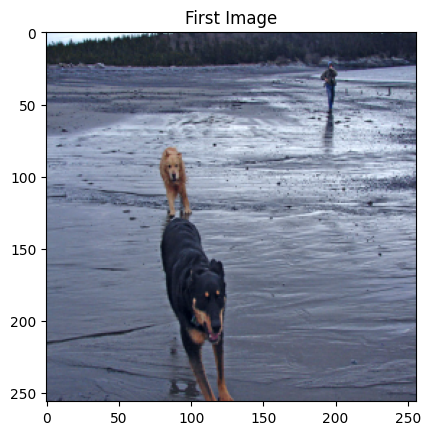

In [10]:
# Test the dataloader
# Fetch one batch
images, captions, caplens = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]
image = images[0].permute(1, 2, 0).numpy()
image = image * 0.225 + 0.45  # De-normalize
plt.title("First Image")
plt.imshow(image)
print(f"First Caption: {captions[0]}")
text_caption = train_dataset.vocab.textualize(captions[0])
print(f"First caption converted: {text_caption}")
print(f"First caption length: {caplens[0]}")

In [11]:
def get_all_caps(dataset, idx):
    image_name = dataset.image_names[idx]
    return dataset.captions_dict[image_name]

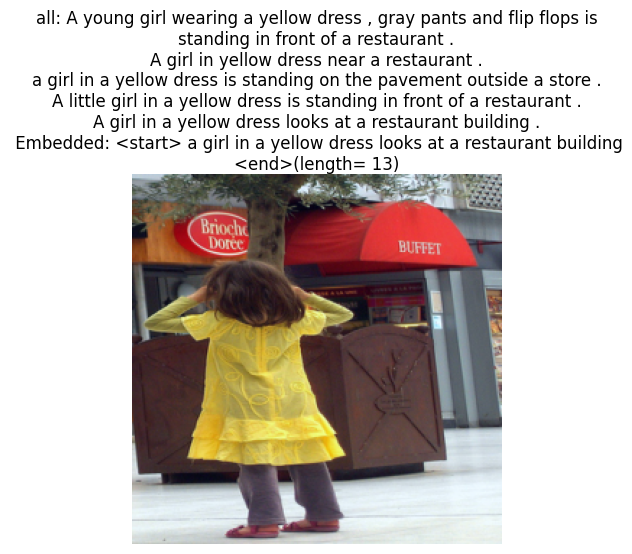

In [12]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption, caption_length = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    text_caption = dataset.vocab.textualize(caption)
    all_caps = "\n".join(get_all_caps(dataset, idx))
    plt.imshow(image)
    # Use this when the idx is for images not captios
    plt.title(f'all: {all_caps}\n Embedded: {text_caption}(length= {str(caption_length)})', fontsize=12, wrap=True)
    # plt.title(f'\n Embedded: {text_caption}(length= {str(caption_length)})', fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

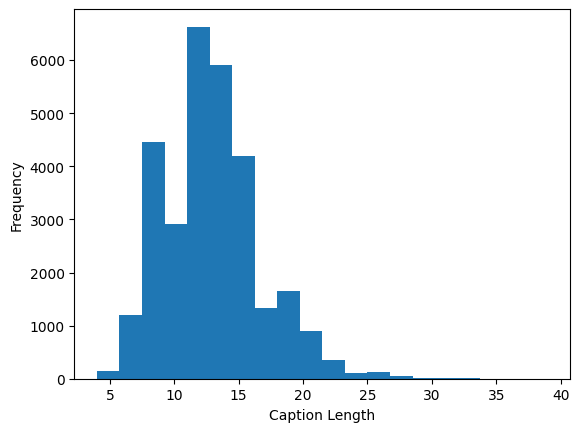

In [13]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


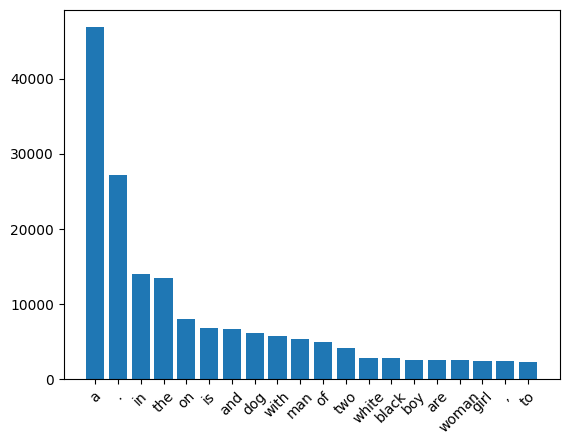

In [14]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# model

In [15]:
# model = models.resnet101(pretrained=True)
# # model = models.vgg16(pretrained=True) 
# # model = models.maxvit_t(pretrained=True) 
# model = models.efficientnet_b0(pretrained=True)
# # model = models.inception_v3(pretrained=True)

# # model = models.mobilenet_v3_small(pretrained=True)
# # model = models.densenet201(pretrained=True)
# print(torchinfo.summary(model, input_size=(4, 3, 256, 256)))

In [16]:
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"Total Parameters: {total_params:,}")
# print(f"Trainable Parameters: {trainable_params:,}")

# for name, layer in model.named_children():
#     print(name, ":", layer)

In [17]:
# feature extractor
class Encoder(nn.Module):
    def __init__(self, fine_tune=True):
        super(Encoder, self).__init__()
        self.fine_tune = fine_tune
        # model = models.resnet101(pretrained=True)
        # # Remove linear and pool layers (since we're not doing classification)
        # modules = list(model.children())[:-2]
        # # nn.Sequential allows you to chain layers together without writing a forward pass manually
        # self.model = nn.Sequential(*modules)

        # model = models.vgg16(pretrained=True) 
        # model = models.inception_v3(pretrained=True)
        # model = models.maxvit_t(pretrained=True) 

        model = models.efficientnet_b0(pretrained=True)
        self.model = model.features
        
        self.set_grad()
    
    def forward(self, images):
        x = self.model(images) # (batch_size, encoder_dim, image_size/32, image_size/32) => [4, 2048, 8, 8]
        x = x.permute(0, 2, 3, 1)
        return x
        
    def set_grad(self):
        # UNFREEZE only the last few layers (4th ResNet block)
        for name, param in self.model.named_parameters():
            # "8." for efficientnet_b0
            # "layer4" for resnet101
            if "8." in name:  # Last residual block (closest to output)
                param.requires_grad = self.fine_tune  # Trainable
            else:
                param.requires_grad = False  # Frozen
        

In [18]:
model = Encoder()
print(f'image feature vector shape: {model(torch.randn(1, 3, 256, 256)).shape}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s] 


image feature vector shape: torch.Size([1, 8, 8, 1280])


In [19]:
# attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out => (batch_size, num_pixels, encoder_dim)
        # decoder_hidden => (batch_size, decoder_dim)
        # convert to attention dim
        att1 = self.encoder_att(encoder_out) # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        # (batch_size, num_pixels, attention_dim) => (batch_size, num_pixels, 1) => (batch_size, num_pixels)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) 
        # attention weights
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        # The final context vector (weighted sum of encoder features based on attention)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [20]:
model = Attention(encoder_dim=1280, decoder_dim=256, attention_dim=256)
attention_weighted_encoding, alpha = model(torch.randn(1, 64, 1280), torch.randn(1, 256))
print(attention_weighted_encoding.shape) # (batch_size, encoder_dim)
print(alpha.shape) # (batch_size, num_pixels)

torch.Size([1, 1280])
torch.Size([1, 64])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [21]:
# word generator
class Decoder(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.dropout = dropout
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # hidden => output at the current time step (short-term memory)
        # cell => internal memory that carries info over time (long-term memory)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.gate_linear = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate

        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        # Dropout randomly zeroes out some elements of input with probability p
        self.dropout = nn.Dropout(p=self.dropout)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
    #     self.init_weights()  # initialize some layers with the uniform distribution for easier convergence

    # def init_weights(self):
    #     self.embedding.weight.data.uniform_(-0.1, 0.1)
    #     self.fc.bias.data.fill_(0)
    #     self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, encoder_out, embedded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        # Flatten image (num_pixels = H * W)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by decreasing lengths
        # improves efficiency (avoids redundant computation for padded tokens)
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        embedded_captions = embedded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(embedded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Using the encoder’s mean feature (instead of zeros) gives the LSTM a starting point informed by the image content
        # initialize h and c states
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for word_num in range(max(decode_lengths)):
            inner_batch_size = sum([l > word_num for l in decode_lengths])
            
            attention_weighted_encoding, alpha = self.attention(encoder_out[:inner_batch_size], h[:inner_batch_size])

            # the model dynamically decides how much attention matters for each word prediction
            gate = self.sigmoid(self.gate_linear(h[:inner_batch_size]))  # gating scalar between 0 and 1, (inner_batch_size, encoder_dim) 
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # input, h0, c0 => h1, c1
            h, c = self.lstm_cell(
                torch.cat([embeddings[:inner_batch_size, word_num, :], attention_weighted_encoding], dim=1),
                (h[:inner_batch_size], c[:inner_batch_size]))  # (inner_batch_size, decoder_dim)
            # Without dropout, the model might overfit to certain word sequence
            preds = self.fc(self.dropout(h))  # (inner_batch_size, vocab_size)
            predictions[:inner_batch_size, word_num, :] = preds
            alphas[:inner_batch_size, word_num, :] = alpha

        return predictions, alphas, sort_ind, embedded_captions, decode_lengths

In [22]:
# class CaptioningModel(nn.Module):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, images, captions, lengths):
#         print(images.shape)
#         print(captions.shape)
#         print(lengths.shape)
#         features = self.encoder(images)
#         outputs = self.decoder(features, captions, lengths)
#         return outputs

# Model parameters

In [53]:
# im order to get encoder dimention

images, captions, caplens = next(iter(train_loader))
model = Encoder()
encoder_dim = model(torch.randn(images.shape)).shape[-1]
print(encoder_dim)

1280


In [54]:
# Model parameters
# decoder
# 512 initially but set to 256 for smaller dataset and not good device speed
embed_dim = 256  # dimension of word embeddings
attention_dim = 256  # dimension of attention linear layers
decoder_dim = 256  # dimension of decoder RNN
dropout = 0.5
vocab_size = len(train_dataset.vocab)
encoder_dim = 1280
# encoder
fine_tune_encoder = True

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
# Higher value because it has been made from scratch
decoder_lr = 4e-4  # learning rate for decoder

In [55]:
encoder = Encoder(fine_tune_encoder).to(device)
decoder = Decoder(encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout).to(device)
# Wrap both parts into one model
# model = CaptioningModel(encoder, decoder)

# loss and optimizer

In [40]:
def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',            # scheduler expects your metric to decrease, because lower loss = better 
        factor=0.8,            # how much to reduce LR (e.g., 0.8 => 20% shrink)
        patience=2,            # wait N epochs with no improvement
        verbose=True           # print when it happens
    )

In [56]:
# the filter() function is filtering out any parameters that do not require gradients, 
# ensuring that only the trainable parameters are passed to the optimizer.
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

# in order to have only one optimizer
# optimizer = torch.optim.Adam([
#     {'params': encoder.parameters(), 'lr': encoder_lr},
#     {'params': decoder.parameters(), 'lr': decoder_lr}
# ])

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

if fine_tune_encoder:
    encoder_scheduler = get_scheduler(encoder_optimizer)
decoder_scheduler = get_scheduler(decoder_optimizer)

In [28]:
# not working with 3 inputs

# from torch_lr_finder import LRFinder

# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
# lr_finder.plot()
# lr_finder.reset()

# Add Checkpoint

In [29]:
# # here
# if val_loss < best_val_loss:
#     best_val_loss = val_loss
#     torch.save(checkpoint, 'best_checkpoint.pth')

# # or here
# if epoch % 5 == 0:  # Save checkpoint every 5 epochs
#     torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')

# Teacher forcing

# Beam search

# Training parameters

In [64]:
epochs = 2
# checkpoint_path = None # path to checkpoint 
# load the checkpoint if you have it
checkpoint_path = 'checkpoint.pth'
print_freq = 10
alpha_c = 1 # controlling the strength of regularization (typically 1.0)
best_bleu4 = 0.  # best BLEU-4 score so far
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
grad_clip = 5.  # clip gradients at an absolute value of
start_epoch = 0

# train

In [43]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    # Performs one epoch's training.

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, alphas, sort_ind, captions_sorted, decode_lengths = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = captions_sorted[:, 1:]

        # Remove the padding, keep track of the sequence lengths, 
        # Pass the packed sequence to the model, so it only processes the valid parts of each sequence
        # decode_lengths: These are the actual lengths (before padding) of each sequence in the batch.
        # batch_first=True -> input tensor shape is (batch_size, seq_len)
        # output => data, batch_size
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores, targets)

        # Doubly Stochastic Regularization: Forces the total attention on each pixel across all timesteps to also sum to 1. This ensures:
        # The model "visits" all relevant regions of the image.
        # Prevents repetitive focus on the same regions.
        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
            if fine_tune_encoder:
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip) 

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Print status
        if i % print_freq == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t ,loss: {loss}')

    return loss

In [32]:
# # in order to understand pack_padded_sequence

# # A padded sequence of shape (batch_size=3, seq_len=5)
# sequences = torch.tensor([
#     [0.5, 0.4, 0.3, 0.2, 0.1],  # Length 5 sequence
#     [0.8, 0.7, 0.6, 0.0, 0.0],  # Length 3 sequence (padded)
#     [1.0, 0.9, 0.0, 0.0, 0.0]   # Length 2 sequence (padded)
# ])

# # Actual lengths of the sequences (before padding)
# seq_lengths = torch.tensor([5, 3, 2]) 
# packed_seq = pack_padded_sequence(sequences, seq_lengths, batch_first=True)
# print(packed_seq.data)
# print(packed_seq.batch_sizes)

# Validation

In [36]:
# Evaluate model performance on unseen validation data
def validate(val_loader, encoder, decoder, criterion, epoch):
    # Performs one epoch's validation.

    decoder.eval()  # eval mode (no dropout or batchnorm)

    if encoder is not None:
        encoder.eval()

    total_loss = 0

    with torch.no_grad():  # Disable gradient tracking
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):
            # Move to GPU, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            allcaps = allcaps.to(device)
    
            # Forward prop.
            imgs = encoder(imgs)
            scores, alphas, sort_ind, captions_sorted, decode_lengths = decoder(imgs, caps, caplens)
    
            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = captions_sorted[:, 1:]
    
            # Remove the padding, keep track of the sequence lengths, 
            # Pass the packed sequence to the model, so it only processes the valid parts of each sequence
            # decode_lengths: These are the actual lengths (before padding) of each sequence in the batch.
            # batch_first=True -> input tensor shape is (batch_size, seq_len)
            # output => data, batch_size
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]
    
            # Calculate loss
            loss = criterion(scores, targets)            

            # At each timestep, attention weights sum to 1 (via softmax). 
            # This ensures the model focuses on specific regions for each word.
            
            # Doubly Stochastic Regularization: Forces the total attention on each pixel across all timesteps to also sum to 1. This ensures:
            # The model "visits" all relevant regions of the image.
            # Prevents repetitive focus on the same regions.
            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            total_loss += loss.item()

            # Process references (ground truth captions)
            # Re-align references with sorted decoder outputs
            sorted_allcaps = allcaps[sort_ind]  # (batch_size, num_captions_per_image, max_caption_length)
            
            # Remove <start> and <pad> tokens from all reference captions
            references = [
                [
                    [token for token in caption.tolist() 
                     if token not in {train_dataset.vocab.stoi["<start>"], train_dataset.vocab.stoi["<pad>"]}]
                    for caption in image_captions
                ]
                for image_captions in sorted_allcaps
            ]
            
            # Process hypotheses (model predictions)
            # Convert raw scores to word indices and remove padding
            _, preds = torch.max(scores_copy, dim=2)  # (batch_size, max_caption_length)
            hypotheses = [
                caption[:length]  # Trim to actual caption length
                for caption, length in zip(preds.cpu().tolist(), decode_lengths)
            ]

            # Sanity check
            assert len(references) == len(hypotheses), "Mismatch between references and hypotheses"

            bleu4 = corpus_bleu(references, hypotheses)  # Compute score

            # Print status
            if i % print_freq == 0:
                print(f'Validation -> Epoch: [{epoch}][{i}/{len(val_loader)}]\t ,loss: {loss}\t ,bleu4: {bleu4}')
            
    avg_loss = total_loss / len(val_loader)
    return avg_loss, bleu4

In [34]:
def update_scheduler(scheduler, val_loss, name=""):
    old_lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = scheduler.optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 {name} learning rate decreased: {old_lr:.6f} ➡️ {new_lr:.6f}")

In [65]:
if checkpoint_path:
    # Loading checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])

    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    best_bleu4 = checkpoint.get('best_bleu4', 0.0)
    loss = checkpoint['loss']
    print(f"Resumed training from epoch {start_epoch} | Best BLEU-4 so far: {best_bleu4:.4f}")

for epoch in range(start_epoch, epochs):
    # terminate training after 20 consecutive epochs with no improvement (early stopping)
    # why 20?  original "Show, Attend and Tell" paper used 20
    # balance between giving the model enough time to improve and avoiding futile training
    if epochs_since_improvement == 20:
        break
            
    # One epoch's training
    loss = train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch)

    # One epoch's validation
    val_loss, last_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion,
                            epoch=epoch)

    if fine_tune_encoder:
        update_scheduler(encoder_scheduler, val_loss, "Encoder")

    update_scheduler(decoder_scheduler, val_loss, "Decoder")

    # Check if there was an improvement
    is_best = last_bleu4 > best_bleu4
    best_bleu4 = max(last_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0
    
    # Saving checkpoint
    checkpoint = {
        'epoch': epoch,  # Save current epoch
        'encoder_state_dict': encoder.state_dict(),  # Save encoder weights
        'decoder_state_dict': decoder.state_dict(),  # Save decoder weights
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict() if encoder_optimizer else None,
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'loss': loss,  # Save the last recorded loss
        'best_bleu4': best_bleu4,
    }

    if is_best:
        torch.save(checkpoint, 'checkpoint_best.pth')

    # Always save last checkpoint
    torch.save(checkpoint, 'checkpoint.pth')
    

<ipython-input-65-c53ac38b1432>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Resumed training from epoch 1 | Best BLEU-4 so far: 0.6481
Epoch: [1][0/188]	 ,loss: 5.112251281738281
Epoch: [1][10/188]	 ,loss: 5.17820930480957
Epoch: [1][20/188]	 ,loss: 5.122002601623535
Epoch: [1][30/188]	 ,loss: 5.2471466064453125
Epoch: [1][40/188]	 ,loss: 4.871142387390137
Epoch: [1][50/188]	 ,loss: 5.135794162750244
Epoch: [1][60/188]	 ,loss: 4.522143363952637
Epoch: [1][70/188]	 ,loss: 5.08753776550293
Epoch: [1][80/188]	 ,loss: 5.12603759765625
Epoch: [1][90/188]	 ,loss: 5.116726875305176
Epoch: [1][100/188]	 ,loss: 5.003497123718262
Epoch: [1][110/188]	 ,loss: 4.742315769195557
Epoch: [1][120/188]	 ,loss: 4.991807460784912
Epoch: [1][130/188]	 ,loss: 4.856208801269531
Epoch: [1][140/188]	 ,loss: 5.181761741638184
Epoch: [1][150/188]	 ,loss: 4.615784645080566
Epoch: [1][160/188]	 ,loss: 5.105645656585693
Epoch: [1][170/188]	 ,loss: 4.6985859870910645
Epoch: [1][180/188]	 ,loss: 4.873825550079346


<ipython-input-4-66a4ffa51371>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_captions_flat = [torch.tensor(cap) for img_caps in allcaps for cap in img_caps]


Validation -> Epoch: [1][0/32]	 ,loss: 7.123061180114746	 ,bleu4: 0.1818890030804552
Validation -> Epoch: [1][10/32]	 ,loss: 7.25508975982666	 ,bleu4: 0.6836339528692135
Validation -> Epoch: [1][20/32]	 ,loss: 7.12219762802124	 ,bleu4: 0.15951181172853435
Validation -> Epoch: [1][30/32]	 ,loss: 7.223916530609131	 ,bleu4: 0.1507414494552202

Epochs since last improvement: 1



In [ ]:
# # observe how to compute BLEU

# from torcheval.metrics.functional.text import bleu_score

# candidates = ["the squirrel is eating the nut"]
# references = [["a squirrel is eating a nut", "the squirrel is eating a tasty nut"]]
# BLEU = bleu_score(candidates, references, n_gram=4)

# print(BLEU)

In [ ]:
# from nltk.translate.bleu_score import corpus_bleu

# weights = (0.1, 0.1, 0.2, 0.6)  # 1-gram: 10%, 2-gram: 10%, 3-gram: 20%, 4-gram: 60%
# # Collect true captions (references) and predictions (hypotheses)
# references = [[["a", "squirrel", "is", "eating", "a", "nut"], ["the", "squirrel", "is", "eating", "a", "tasty", "nut"]]]  
# hypotheses = [["the", "squirrel", "is", "eating", "the", "nut"]]             
# bleu4 = corpus_bleu(references, hypotheses, weights=weights)  # Compute score

# print(bleu4)

# Test

In [66]:
# evaluate and report model performance
# TODO:
# 1. Load the Model
# 2. Set to Eval Mode
# 3. Iterate Over the Test Dataset
# 4. Compute Evaluation Metrics

In [67]:
# TODO:it can also return the attention weights
def generate_caption_beam_search(encoder, decoder, image, word_map, beam_size=5, max_len=50):
    k = beam_size
    vocab_size = len(word_map)

    encoder_out = encoder(image.unsqueeze(0))  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(-1)
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # Repeat tensor k times for beam search
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

    # Initialize sequences to <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(image.device)  # (k, 1)
    seqs = k_prev_words  # (k, 1)

    # Log probabilities
    top_k_scores = torch.zeros(k, 1).to(image.device)

    complete_seqs = []
    complete_seqs_scores = []

    # Initial hidden and cell states
    h, c = decoder.init_hidden_state(encoder_out)

    step = 1
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (k, embed_dim)
        awe, _ = decoder.attention(encoder_out, h)  # (k, encoder_dim), (_,)
        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar
        awe = gate * awe
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (k, decoder_dim)
        scores = decoder.fc(h)  # (k, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores

        # Get top k
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        # Convert to seq indices
        prev_word_inds = top_k_words // vocab_size
        next_word_inds = top_k_words % vocab_size

        # Append
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

        # Check for complete
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Save complete
        for ind in complete_inds:
            complete_seqs.append(seqs[ind].tolist())
            complete_seqs_scores.append(top_k_scores[ind])

        k -= len(complete_inds)  # reduce beam length

        if k == 0 or step > max_len:
            break

        # Continue with incomplete sequences
        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    return complete_seqs[i]


In [ ]:
def evaluate(encoder, decoder, data_loader, word_map, beam_size=5):
    references = []
    hypotheses = []

    encoder.eval()
    decoder.eval()

    for i, (image, caps, caplens, all_caps) in enumerate(data_loader):
        image = image.to(device)

        # Generate caption using beam search
        seq = generate_caption_beam_search(encoder, decoder, image.squeeze(0), word_map, beam_size)

        # Decode sequences
        pred = [rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<pad>']}]
        hypotheses.append(pred)

        # Ground truth (all refs for BLEU/CIDEr)
        img_refs = []
        for cap in all_caps[0].tolist():
            img_refs.append([rev_word_map[ind] for ind in cap if ind not in {word_map['<start>'], word_map['<pad>']}])
        references.append(img_refs)

    # Now evaluate using pycocoevalcap or nltk
    bleu4 = corpus_bleu(references, hypotheses)
    print(f"BLEU-4 score: {bleu4:.4f}")

    # More metrics?
    # Use pycocoevalcap for CIDEr, METEOR, etc.


# Test on your own data

In [ ]:
# 1. Preprocess image
# 2. Pass through encoder
# 3. Decode using beam search
# 4. Get indices → map to words → join into sentence

# TTS

# Save outputs for next time

In [ ]:
!zip -r saved_data.zip /kaggle/working/